In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from IPython import display
import math
from sklearn.preprocessing import StandardScaler

In [2]:
from torch.utils.data import DataLoader, TensorDataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/Multi_core/proprocessed_data_s_p_speedup.csv')
# data = pd.read_csv('../data/prepocessed_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
x_col = ['cache-misses', 'dTLB-load-misses', 'time',	'branch-load-misses',	'L1-icache-load-misses',
         'cpu-cycles', 'L1-dcache-load-misses', 'dTLB-loads',	'cpu-used']
y_col = ['Speedup']

In [5]:
X = data[x_col]
y = data[y_col]

In [6]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [7]:
# train test split
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

In [8]:
X_train_tensor = torch.from_numpy(X_train.values)
y_train_tensor = torch.from_numpy(y_train.values)
X_val_tensor = torch.from_numpy(X_val.values)
y_val_tensor = torch.from_numpy(y_val.values)
X_test_tensor = torch.from_numpy(X_test.values)
y_test_tensor = torch.from_numpy(y_test.values)

In [9]:
print("X_train_Size: " + str(X_train_tensor.shape))
print("y_train_Size: " + str(y_train_tensor.shape))
print("X_val_Size: " + str(X_val_tensor.shape))
print("y_val_Size: " + str(y_val_tensor.shape))
print("X_test: " + str(X_test_tensor.shape))
print("y_test_Size: " + str(y_test_tensor.shape))

X_train_Size: torch.Size([6804, 9])
y_train_Size: torch.Size([6804, 1])
X_val_Size: torch.Size([1458, 9])
y_val_Size: torch.Size([1458, 1])
X_test: torch.Size([1459, 9])
y_test_Size: torch.Size([1459, 1])


In [10]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [11]:
X_train.head()

,cache-misses,dTLB-load-misses,time,branch-load-misses,L1-icache-load-misses,cpu-cycles,L1-dcache-load-misses,dTLB-loads,cpu-used
2321,-0.439963,-0.207233,-0.476484,-0.265306,0.084274,-0.223208,-0.302888,-0.255356,0.637531
6842,-0.529780,-0.234014,-0.413167,-0.509105,-0.055845,-0.482609,-0.442201,-0.486404,-0.241699
3055,2.815560,7.432774,2.433144,0.776879,2.831968,0.881707,0.308237,-0.199900,-0.558165
151,-0.403779,-0.144154,-0.495228,-0.402860,0.062750,-0.642390,-0.445776,-0.606420,-0.545993
3799,-0.522463,-0.240333,-0.641022,-0.593708,-0.294648,-0.763725,-0.539069,-0.685950,-0.624035


In [12]:
I = 9  # input feature
O = 1 # output result
H = 64 # hidden unit

In [13]:
model = nn.Sequential(
    nn.Linear(I, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, O)
)
model = model.to(torch.float64)

In [14]:
weight_tensor = model[0].weight

# Get the datatype of the weight tensor
weight_tensor.dtype

torch.float64

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
def train(model, loader, optimizer):
    loss_sum = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(loader):
        optimizer.zero_grad()
        output = model(inputs)
        loss = torch.nn.functional.mse_loss(output, targets)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        
    avg_loss = loss_sum / len(loader)
    print(f"Train MSE loss: {avg_loss:.4f}")
    return avg_loss

In [17]:
train_losses = []
train_rmses = []
train_maes = []
val_losses = []
val_rmses = []
val_maes = []

In [18]:
#train
for epoch in range(500):
    print(f"Epoch {epoch + 1}")
    train_loss = train(model, train_loader, optimizer)
    train_losses.append(train_loss)

    with torch.no_grad():
        mae_sum = 0.0
        rmse_sum = 0.0
        total = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            output = model(inputs)
            mae_sum += torch.abs(output - targets).sum().item()
            rmse_sum += torch.square(output - targets).sum().item()
            total += len(targets)
        mae = mae_sum / total
        rmse = math.sqrt(rmse_sum / total)
        train_rmses.append(rmse)
        train_maes.append(mae)
        print(f"Train MSE: {train_loss:.4f}, Train MAE: {mae:.4f}, Train RMSE: {rmse:.4f}")
    
    # validation
    with torch.no_grad():
        loss_sum = 0.0
        val_mae_sum = 0.0
        val_rmse_sum = 0.0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            output = model(inputs)
            loss = torch.nn.functional.mse_loss(output, targets)
            loss_sum += loss.item()
            val_mae_sum += torch.abs(output - targets).sum().item()
            val_rmse_sum += torch.square(output - targets).sum().item()
            total += len(targets)

        avg_loss = loss_sum / len(test_loader)
        val_losses.append(avg_loss)
        val_mae = val_mae_sum / total
        val_rmse = math.sqrt(val_rmse_sum / total)
        val_rmses.append(val_rmse)
        val_maes.append(val_mae)
        print(f"Test MSE: {avg_loss:.4f}, Test MAE: {val_mae:.4f}, Test RMSE: {val_rmse:.4f}")
    # display.clear_output(wait=True)

Epoch 1
Train MSE loss: 3.8029
Train MSE: 3.8029, Train MAE: 0.9393, Train RMSE: 1.3218
Test MSE: 1.7154, Test MAE: 0.9412, Test RMSE: 1.3159
Epoch 2
Train MSE loss: 1.4313
Train MSE: 1.4313, Train MAE: 0.7104, Train RMSE: 1.0618
Test MSE: 1.1298, Test MAE: 0.7137, Test RMSE: 1.0660
Epoch 3
Train MSE loss: 0.9615
Train MSE: 0.9615, Train MAE: 0.5914, Train RMSE: 0.8771
Test MSE: 0.7994, Test MAE: 0.5965, Test RMSE: 0.8968
Epoch 4
Train MSE loss: 0.7235
Train MSE: 0.7235, Train MAE: 0.5335, Train RMSE: 0.7848
Test MSE: 0.6482, Test MAE: 0.5405, Test RMSE: 0.8089
Epoch 5
Train MSE loss: 0.6037
Train MSE: 0.6037, Train MAE: 0.5012, Train RMSE: 0.7352
Test MSE: 0.5853, Test MAE: 0.5137, Test RMSE: 0.7675
Epoch 6
Train MSE loss: 0.5340
Train MSE: 0.5340, Train MAE: 0.5000, Train RMSE: 0.7457
Test MSE: 0.6024, Test MAE: 0.5162, Test RMSE: 0.7760
Epoch 7
Train MSE loss: 0.5049
Train MSE: 0.5049, Train MAE: 0.4807, Train RMSE: 0.6962
Test MSE: 0.5252, Test MAE: 0.4897, Test RMSE: 0.7249
Epoch 

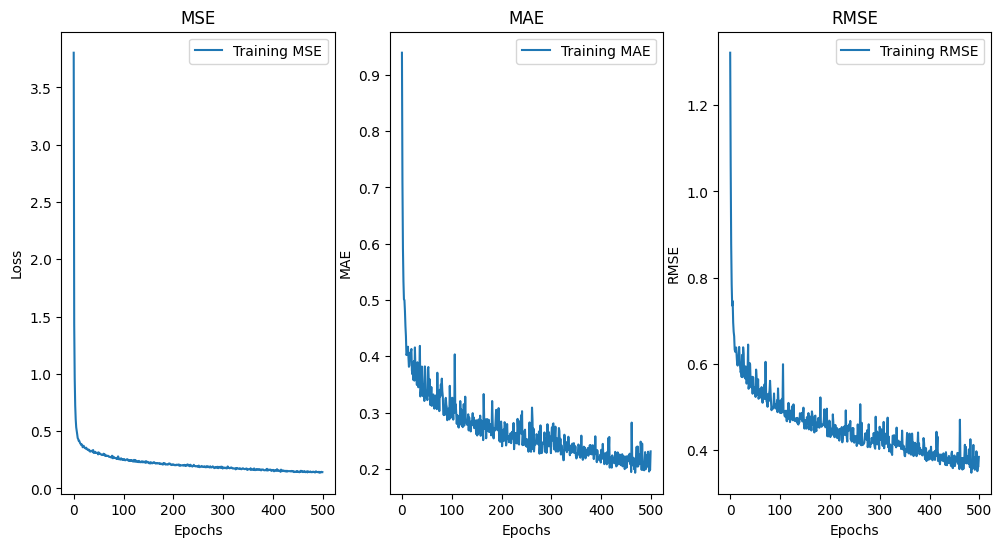

In [19]:
# train loss, mae, rmse
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# plot the MSE values
ax1.plot(train_losses, label='Training MSE')
ax1.set_title('MSE')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# plot the MAE values
ax2.plot(train_maes, label='Training MAE')
ax2.set_title('MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.legend()

# plot the RMSE values
ax3.plot(train_rmses, label='Training RMSE')
ax3.set_title('RMSE')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('RMSE')
ax3.legend()

# show the plot
plt.show()

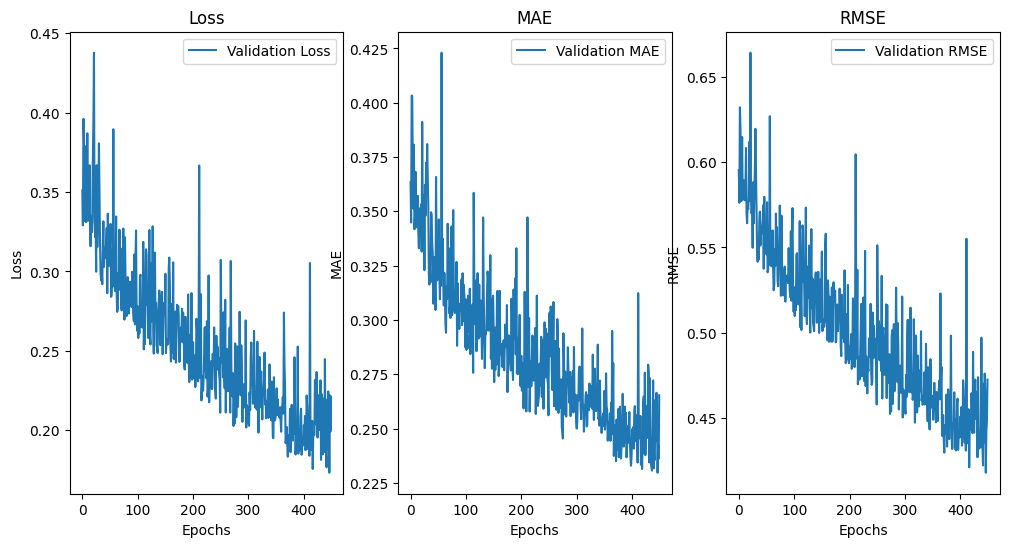

In [20]:
# val loss, accuracy
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# plot the MSE values
ax1.plot(val_losses[50:], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# plot the MAE values
ax2.plot(val_maes[50:], label='Validation MAE')
ax2.set_title('MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.legend()

# plot the RMSE values
ax3.plot(val_rmses[50:], label='Validation RMSE')
ax3.set_title('RMSE')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('RMSE')
ax3.legend()

# show the plot
plt.show()

In [21]:
with torch.no_grad():
  y_pred = model(X_test_tensor).detach().numpy()

In [22]:
# Calculate MAE
mae = mean_absolute_error(y_test.values.reshape(-1), y_pred)
print("MAE:", mae)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test.values.reshape(-1), y_pred))
print("RMSE:", rmse)

MAE: 0.27229130360749493
RMSE: 0.4647000846017238


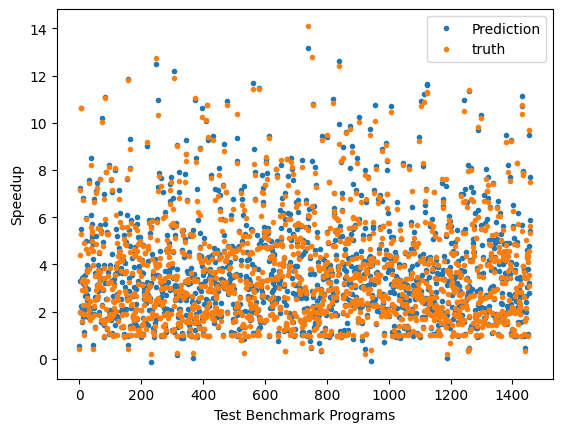

In [23]:
plt.plot(np.array([i for i in range(len(y_pred))]), y_pred.reshape(-1), '.', label="Prediction")
plt.plot(np.array([i for i in range(len(y_pred))]), y_test.values.reshape(-1), '.', label="truth")
plt.xlabel("Test Benchmark Programs")
plt.ylabel("Speedup")
plt.legend()
plt.show()